In [ ]:
!pip install tensorflow==2.12.0 keras-facenet==0.3.1 mtcnn==0.1.1 deepface==0.0.79 annoy==1.17.3
#====== 掛載Google Drive ======
from google.colab import drive
drive.mount('/content/drive')
#====== 創建項目目錄 ======
import os

BASE_PATH = '/content/drive/MyDrive/FaceAuthSystem'
REQUIRED_DIRS = ['database', 'test_images', 'models']

for dir_name in REQUIRED_DIRS:
  dir_path = os.path.join(BASE_PATH, dir_name)
  os.makedirs(dir_path, exist_ok=True)
  print(f"✅ 已確認目錄存在: {dir_path}")

!ls -l "{BASE_PATH}"

  Using cached keras_facenet-0.3.1-py3-none-any.whl.metadata (2.3 kB)
Using cached keras_facenet-0.3.1-py3-none-any.whl (11 kB)
  Attempting uninstall: keras-facenet
    Found existing installation: keras-facenet 0.3.2
    Uninstalling keras-facenet-0.3.2:
      Successfully uninstalled keras-facenet-0.3.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 已確認目錄存在: /content/drive/MyDrive/FaceAuthSystem/database
✅ 已確認目錄存在: /content/drive/MyDrive/FaceAuthSystem/test_images
✅ 已確認目錄存在: /content/drive/MyDrive/FaceAuthSystem/models
total 12
drwx------ 2 root root 4096 Jan 24 13:07 database
drwx------ 2 root root 4096 Jan 24 13:07 models
drwx------ 2 root root 4096 Jan 24 13:07 test_images


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mtcnn import MTCNN
from keras_facenet import FaceNet
from annoy import AnnoyIndex

print("⏳ 初始化人臉檢測器...")
detector = MTCNN(
    min_face_size=50,  # 過濾過小人臉
    steps_threshold=[0.6, 0.7, 0.7],
    scale_factor=0.8
)

print("⏳ 加載FaceNet模型...")
try:
    embedder = FaceNet()
    print("✅ FaceNet加載成功!")
except Exception as e:
    print(f"❌ 模型加載失敗: {str(e)}")
    # 備用方案
    !pip install -U keras-facenet
    from keras_facenet import FaceNet
    embedder = FaceNet()

⏳ 初始化人臉檢測器...
⏳ 加載FaceNet模型...
✅ FaceNet加載成功!


In [ ]:
#coding: utf-8

import os
import re
import cv2
import numpy as np
from urllib.parse import quote
from mtcnn import MTCNN
from keras_facenet import FaceNet
from annoy import AnnoyIndex
from matplotlib import pyplot as plt

#配至
BASE_PATH = '/content/drive/MyDrive/FaceAuthSystem'  # 基礎路徑
ALLOWED_ID_PATTERN = r'^[a-zA-Z0-9_-]{4,20}$'# 合法用戶ID格式
SAVE_IMAGE_FORMAT = 'png'# 圖像保存格式
MIN_FACE_CONFIDENCE = 0.95
FACE_SIZE = (160, 160)
INDEX_TREES = 10

class FaceUtils:
    @staticmethod
    def validate_user_id(user_id):
        """ 用戶ID合法性驗證 """
        if not re.match(ALLOWED_ID_PATTERN, user_id):
            raise ValueError(f"無效用戶ID: {user_id}\n格式要求: 字母/數字/下劃線/減號, 4-20位")
        return user_id

    @staticmethod
    def safe_filename(user_id):
        """ 生成安全文件名 """
        return quote(user_id, safe='')

    @classmethod
    def show_image_comparison(cls, raw_img, processed_img):
        """ 圖像處理對比可視化 """
        plt.figure(figsize=(12, 6))
        plt.subplot(121), plt.imshow(raw_img), plt.title('原始裁剪')
        plt.subplot(122), plt.imshow(processed_img), plt.title('處理後')
        plt.show()

# ======================= 註冊模塊 =======================
class FaceRegister:
    def __init__(self):
        """ 初始化人臉註冊組件 """
        self.detector = MTCNN(
            min_face_size=50,
            steps_threshold=[0.6, 0.7, 0.7],
            scale_factor=0.8
        )
        self.embedder = FaceNet()

    def _process_face(self, img_path):
        """ 人臉圖像處理核心方法 """
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        results = self.detector.detect_faces(img)
        if not results:
            raise ValueError("未檢測到有效人臉")

        main_face = max(results, key=lambda x: x['confidence'])
        if main_face['confidence'] < MIN_FACE_CONFIDENCE:
            raise ValueError(f"人臉質量不足 (可信度: {main_face['confidence']:.2f})")

        x, y, w, h = (max(0, v) for v in main_face['box'])
        face_roi = img[y:y+h, x:x+w]

        face_img = cv2.resize(
            face_roi,
            FACE_SIZE,
            interpolation=cv2.INTER_LANCZOS4
        )
        return face_roi, face_img

    def register(self, img_path, user_id, debug=False):
        """ 增強版用戶註冊方法 """
        try:
            user_id = FaceUtils.validate_user_id(user_id)
            safe_id = FaceUtils.safe_filename(user_id)

            if not os.path.exists(img_path):
                raise FileNotFoundError(f"圖片路徑不存在: {img_path}")

            raw_face, processed_face = self._process_face(img_path)

            if debug:
                FaceUtils.show_image_comparison(raw_face, processed_face)

            embedding = self.embedder.embeddings([processed_face])[0]#特徵

            # 保存數據
            np.save(f"{BASE_PATH}/database/{safe_id}.npy", embedding)
            cv2.imwrite(
                f"{BASE_PATH}/database/{safe_id}.{SAVE_IMAGE_FORMAT}",
                cv2.cvtColor(processed_face, cv2.COLOR_RGB2BGR),
                [cv2.IMWRITE_PNG_COMPRESSION, 0] if SAVE_IMAGE_FORMAT == 'png' else []
            )

            print(f"✅ 用戶註冊成功 | ID: {user_id} | 特徵維度: {embedding.shape}")
            return True

        except Exception as e:
            print(f"❌ 註冊失敗: {str(e)}")
            return False

class FaceRecognizer:
    def __init__(self, threshold=0.5):
        """ 初始化人臉識別組件 """
        self._configure_hardware()

        self.detector = MTCNN(
            min_face_size=50,
            steps_threshold=[0.6, 0.7, 0.7],
            scale_factor=0.8
        )
        self.embedder = FaceNet()
        self.threshold = threshold

        self._init_database()
        self._build_index()

    def _configure_hardware(self):
        """ 硬件加速配置 """
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                print("✅ GPU加速已啟用")
            except RuntimeError as e:
                print(f"⚠️ GPU配置失敗: {str(e)}")

    def _init_database(self):
        """ 數據庫初始化 """
        self.user_ids = []
        self.embeddings = []
        db_path = f"{BASE_PATH}/database"

        if not os.path.exists(db_path):
            raise FileNotFoundError(f"數據庫目錄不存在: {db_path}")

        valid_count = 0
        for fname in os.listdir(db_path):
            if fname.endswith('.npy'):
                try:
                    user_id = os.path.splitext(fname)[0]
                    emb = np.load(f"{db_path}/{fname}")
                    if emb.shape[0] != 512:
                        raise ValueError(f"特徵維度不匹配: {emb.shape}")

                    self.user_ids.append(user_id)
                    self.embeddings.append(emb)
                    valid_count += 1
                except Exception as e:
                    print(f"⚠️ 加載失敗: {fname} - {str(e)}")

        if valid_count == 0:
            raise ValueError("數據庫為空或數據損壞，請重新註冊用戶")
        print(f"✅ 數據庫加載完成 | 有效用戶數: {valid_count}")

    def _build_index(self):
        """ 構建特徵索引 """
        self.index = AnnoyIndex(512, 'angular')
        for i, emb in enumerate(self.embeddings):
            self.index.add_item(i, emb)
        self.index.build(INDEX_TREES)
        print(f"✅ 特徵索引構建完成 | 索引規模: {self.index.get_n_items()}")

    def _safe_search(self, query_emb):
        """ 安全相似度搜索 """
        try:
            ids, dists = self.index.get_nns_by_vector(
                query_emb,
                n=3,  # 取前3個候選
                include_distances=True
            )
            if not ids:
                return None, 0.0
            return ids[0], 1 - dists[0]**2 / 2
        except Exception as e:
            print(f"⚠️ 索引搜索失敗: {str(e)}")
            return None, 0.0

    def recognize(self, img_path, debug=False):
        """ 增強版人臉識別 """
        try:
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"圖片路徑不存在: {img_path}")

            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            # 人臉檢測
            results = self.detector.detect_faces(img)
            if not results:
                print("⚠️ 未檢測到有效人臉")
                return None

            main_face = max(results, key=lambda x: x['confidence'])
            x, y, w, h = (max(0, v) for v in main_face['box'])
            face_img = cv2.resize(
                img[y:y+h, x:x+w],
                FACE_SIZE,
                interpolation=cv2.INTER_LANCZOS4
            )

            if debug:
                FaceUtils.show_image_comparison(img[y:y+h, x:x+w], face_img)

            query_emb = self.embedder.embeddings([face_img])[0]
            best_idx, similarity = self._safe_search(query_emb)

            if similarity >= self.threshold:
                print(f"✅ 識別成功 | 用戶: {self.user_ids[best_idx]} | 相似度: {similarity:.2f}")
                return self.user_ids[best_idx]
            else:
                print(f"⚠️ 未授權人員 | 最高相似度: {similarity:.2f}")
                return None

        except Exception as e:
            print(f"❌ 識別過程出錯: {str(e)}")
            return None

✅ 數據庫加載完成 | 有效用戶數: 12
✅ 特徵索引構建完成 | 索引規模: 12
1/1 [==============================] - 0s 179ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35009 (\N{CJK UNIFIED IDEOGRAPH-88C1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21098 (\N{CJK UNIFIED IDEOGRAPH-526A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34389 (\N{CJK UNIFIED IDEOGRAPH-8655}) missing from font(s) DejaVu Sans.
  fig.canvas

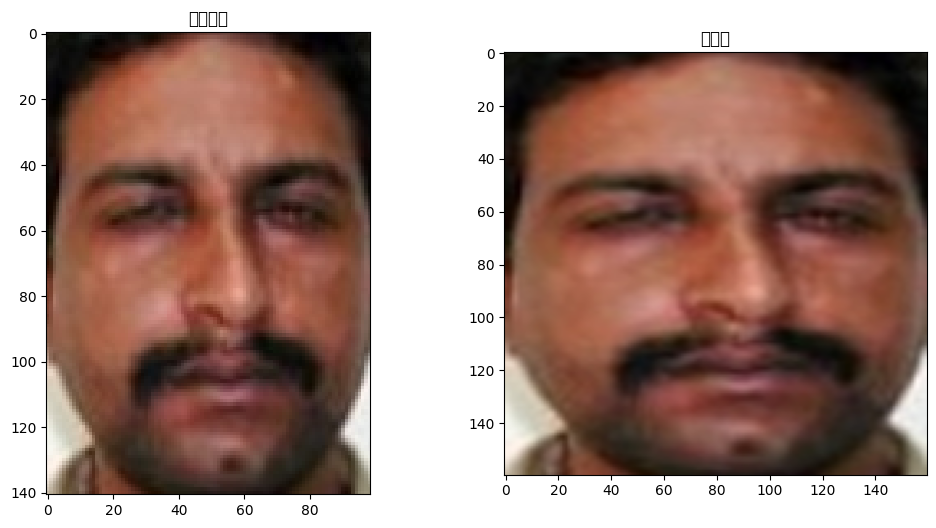

1/1 [==============================] - 3s 3s/step
✅ 用戶註冊成功 | ID: Zulfiqar_Ahmed | 特徵維度: (512,)
註冊測試通過


In [ ]:
if __name__ == "__main__":
    register = FaceRegister()
    recognizer = FaceRecognizer(threshold=0.5)

    test_img = "/content/drive/MyDrive/known_faces/Zulfiqar_Ahmed_0001.jpg"
    if register.register(test_img, "Zulfiqar_Ahmed", debug=True):
        print("註冊測試通過")

In [ ]:
# 檢查數據內容
db_path = f"{BASE_PATH}/database"
print("數據庫文件列表:", os.listdir(db_path))


In [ ]:
人臉識別
test_img = "/content/drive/MyDrive/unknown_faces/William_Ford_Jr_0006.jpg"#之後可能再改一下路徑
print("\n正在進行識別測試...")
result = recognizer.recognize(test_img, debug=True)
print("識別測試結果:", "授權通過" if result else "未授權")